# 1x4 MMI power splitter

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

Optical power splitters are essential components in integrated photonics. Power splitters based on multimode interference (MMI) device are easy to fabricate and can achieve low excess loss as well as large bandwidth. Although the design of a MMI power splitter is based on the self-imaging principle, fine-tuning the geometric parameters with accurate and fast numerical simulations is crucial to achieving optimal device performance. 

This example aims to demonstrate the design and optimization of 1 to 4 MMI device at telecom wavelength for power splitting applications. The initial design is adapted from [D. Malka, Y. Danan, Y. Ramon, Z. Zalevsky, A Photonic 1 x 4 Power Splitter Based on Multimode Interference in Silicon–Gallium-Nitride Slot Waveguide Structures. Materials. 9, 516 (2016)](https://www.mdpi.com/1996-1944/9/7/516).

The device uses a Si-GaN-Si slot waveguide strcuture as schematically shown below.

<img src="img/mmi_schematic.png" width="300" alt="Schematic of the MMI">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

## Simulation Setup 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver


Define materials. There are three materials involved in this model. The SiO2 cladding and the Si waveguide with GaN slot. All materials are modeled as lossless and dispersionless in this particular case.

In [2]:
# material refractive indices
n_si = 3.48
n_gan = 2.305
n_sio2 = 1.444

# define media
si = td.Medium(permittivity=n_si**2)
gan = td.Medium(permittivity=n_gan**2)
sio2 = td.Medium(permittivity=n_sio2**2)


Define initial design parameters and wrap simulation setup in a function. The arguments of the function are the paremeters we want to optimize later. In this example, we aim to optimize the length and width of the MMI section.

In [3]:
W_MMI = 5  # width of the MMI section
L_MMI = 11.2  # length of the MMI section
g1 = 0.9  # gap between the output waveguides
W1 = 0.4  # width of the waveguide
W2 = 0.8  # width of the tapper
L1 = 2  # length of the input tapper
L2 = 5  # length of the output tapper
H_Si = 0.3  # thickness of the Si layer
H_GaN = 0.1  # thickness of the GaN layer
g3 = (W2 - W1) / 2  # auxilary parameter defined for easier geometry building
g2 = g1 - 2 * g3  # gap between the output tapers
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

# buffer spacings in the x and y directions.
buffer_x = 1
buffer_y = 1.5

# define a function that takes the geometric parameters as input arguments and return a Simulation object
def make_sim(L_MMI, W_MMI):
    # the whole device is defined as a PolySlab with vertices given by the following
    vertices = np.array(
        [
            (-W1 / 2, -100),
            (-W1 / 2, 0),
            (-W2 / 2, L1),
            (-W_MMI / 2, L1),
            (-W_MMI / 2, L1 + L_MMI),
            (-g2 / 2 - W2 - g2 - 2 * g3 - W1, L1 + L_MMI),
            (-g2 / 2 - W2 - g2 - g3 - W1, L1 + L_MMI + L2),
            (-g2 / 2 - W2 - g2 - g3 - W1, 100),
            (-g2 / 2 - W2 - g2 - g3, 100),
            (-g2 / 2 - W2 - g2 - g3, L1 + L_MMI + L2),
            (-g2 / 2 - W2 - g2, L1 + L_MMI),
            (-g2 / 2 - W2, L1 + L_MMI),
            (-g1 / 2 - W1, L1 + L_MMI + L2),
            (-g1 / 2 - W1, 100),
            (-g1 / 2, 100),
            (-g1 / 2, L1 + L_MMI + L2),
            (-g2 / 2, L1 + L_MMI),
            (g2 / 2, L1 + L_MMI),
            (g1 / 2, L1 + L_MMI + L2),
            (g1 / 2, 100),
            (g1 / 2 + W1, 100),
            (g1 / 2 + W1, L1 + L_MMI + L2),
            (g2 / 2 + W2, L1 + L_MMI),
            (g2 / 2 + W2 + g2, L1 + L_MMI),
            (g2 / 2 + W2 + g2 + g3, L1 + L_MMI + L2),
            (g1 / 2 + W1 + g1, 100),
            (g1 / 2 + W1 + g1 + W1, 100),
            (g2 / 2 + W2 + g2 + g3 + W1, L1 + L_MMI + L2),
            (g2 / 2 + W2 + g2 + 2 * g3 + W1, L1 + L_MMI),
            (W_MMI / 2, L1 + L_MMI),
            (W_MMI / 2, L1),
            (W2 / 2, L1),
            (W1 / 2, 0),
            (W1 / 2, -100),
        ]
    )

    mmi_layer1 = td.Structure(
        geometry=td.PolySlab(
            vertices=vertices,
            axis=2,
            slab_bounds=(-H_Si - 0.5 * H_GaN, H_Si + 0.5 * H_GaN),
        ),
        medium=si,
    )
    mmi_layer2 = td.Structure(
        geometry=td.PolySlab(
            vertices=vertices, axis=2, slab_bounds=(-0.5 * H_GaN, 0.5 * H_GaN)
        ),
        medium=gan,
    )

    # simulation domain size
    Lx = W_MMI + 2 * buffer_x
    Ly = L1 + L_MMI + L2 + 2 * buffer_y
    Lz = 5 * (H_GaN * 2 + H_Si)
    sim_size = (Lx, Ly, Lz)

    mode_spec = td.ModeSpec(num_modes=2, target_neff=n_si)

    # add a mode source for excitation
    mode_source = td.ModeSource(
        center=(0, -buffer_y / 3, 0),
        size=(5 * W1, 0, Lz),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
        num_freqs=5,
    )

    # add two flux monitors to monitor the transmission power at output waveguides
    flux_monitor1 = td.FluxMonitor(
        center=((g1 + W1) / 2, Ly - buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        name="flux1",
    )

    flux_monitor2 = td.FluxMonitor(
        center=(3 * (g1 + W1) / 2, Ly - buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        name="flux2",
    )

    # add two mode monitors to monitor the mode profiles at output waveguides
    mode_monitor1 = td.ModeMonitor(
        center=((g1 + W1) / 2, Ly - buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode1",
    )

    mode_monitor2 = td.ModeMonitor(
        center=(3 * (g1 + W1) / 2, Ly - buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode2",
    )

    # add a field monitor to monitor the field distribution
    field_monitor = td.FieldMonitor(
        center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )

    sim = td.Simulation(
        center=(0, Ly / 2 - buffer_y / 2, 0),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=td.C_0 / freq0),
        structures=[mmi_layer1, mmi_layer2],
        sources=[mode_source],
        monitors=[
            field_monitor,
            flux_monitor1,
            flux_monitor2,
            mode_monitor1,
            mode_monitor2,
        ],
        run_time=5e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
        symmetry=(1, 0, -1),
    )
    return sim


## Initial Design

First, we simulate an initial design using the previously defined design parameters.

[13:11:00] WARNING: Default value for the field monitor           ]8;id=549179;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=203310;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

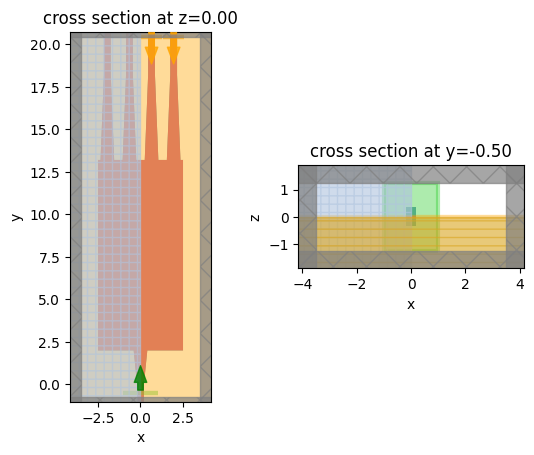

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)
sim = make_sim(L_MMI, W_MMI)
sim.plot(z=0, ax=ax1)
sim.plot(y=-buffer_y / 3, ax=ax2)
plt.show()


Before simulation, let's inspect the waveguide modes supported in the slot waveguide to make sure we are using the correct excitation source. 

In [5]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=sim.sources[0].center, size=sim.sources[0].size),
    mode_spec=sim.sources[0].mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()


           WARNING: Use the remote mode solver with subpixel  ]8;id=720739;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=272315;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py#141\141]8;;\
           averaging for better accuracy through                                
           'tidy3d.plugins.mode.web.run(...)'.                                  

The lowest order mode shows a strong field confinement between the Si area. This is the mode we want to use as excitation.

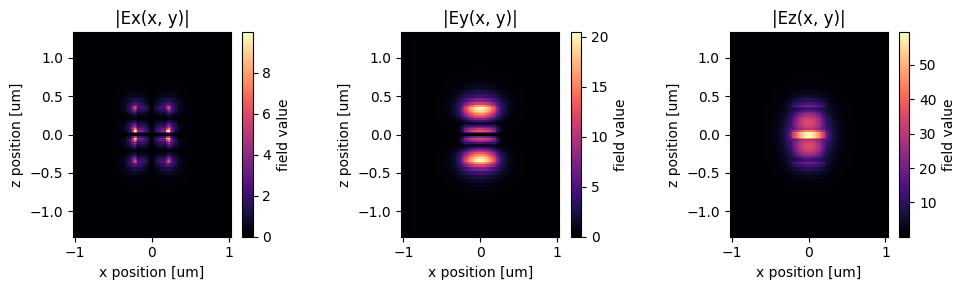

In [6]:
mode_index = 0

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=mode_index)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=mode_index)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=mode_index)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, y)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, y)|")
ax3.set_aspect("equal")
plt.show()


Submit simulation job to the server. 

In [7]:
job = web.Job(simulation=sim, task_name="mmi", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


[13:11:02] Created task 'mmi' with task_id                         ]8;id=979876;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=430987;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1'.                       

           View task using web UI at                               ]8;id=548298;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=412441;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=554614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=743643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1\taskId]8;;\]8;id=554614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1\=]8;;\]8;id=620095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1\fdve]8;;\]8;id=554614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1\-]8;;\              
           ]8;id=554614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e80a90ee-0702-4221-9545-8a6d1f1eb71dv1\e80a90ee-0702-4221-9545-8a6d1f1eb71dv1']8;;\.                             

Output()

[13:11:03] status = queued                                         ]8;id=953495;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=151408;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[13:11:18] status = preprocess                                     ]8;id=184392;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=928663;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[13:11:23] Maximum FlexCredit cost: 0.251. Use                     ]8;id=567856;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=443794;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=340828;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=536032;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=236420;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=726465;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=121904;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121094;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[13:12:47] early shutoff detected, exiting.                        ]8;id=643082;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=120815;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=610207;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=208329;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[13:13:10] status = success                                        ]8;id=487378;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=181113;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[13:13:11] loading SimulationData from data/simulation_data.hdf5   ]8;id=125019;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=51511;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

Visualize the field distribution.

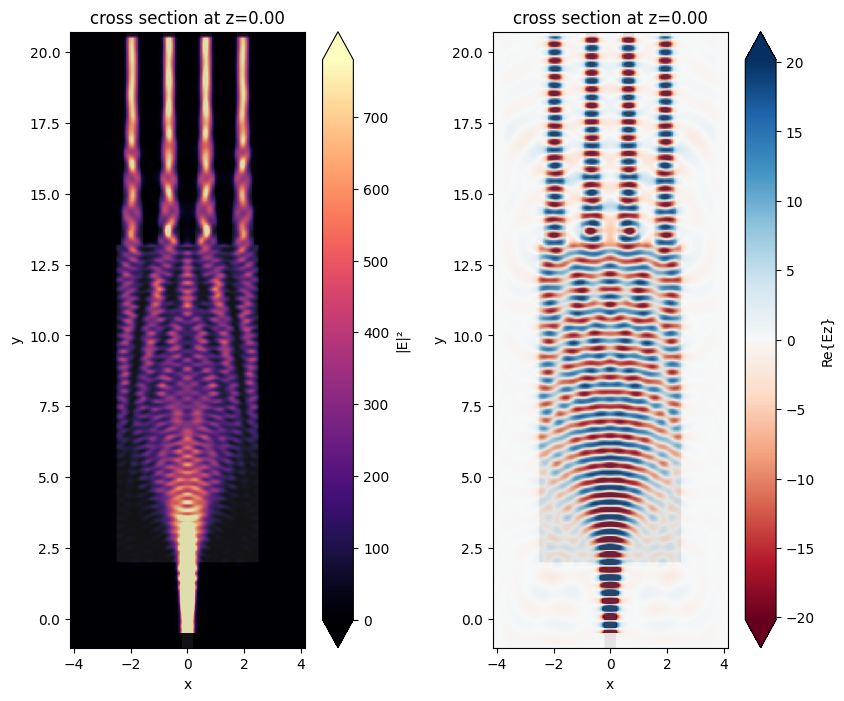

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", ax=ax1, f=freq0
)
sim_data.plot_field(field_monitor_name="field", field_name="Ez", ax=ax2, f=freq0)
plt.show()


Plot transmission on each output waveguide as well as the total excess loss. At the central wavelength of 1550 nm, the transimission power at the inner waveguide and outer waveguide differs by about 2%. The excess loss is about 0.4 dB.

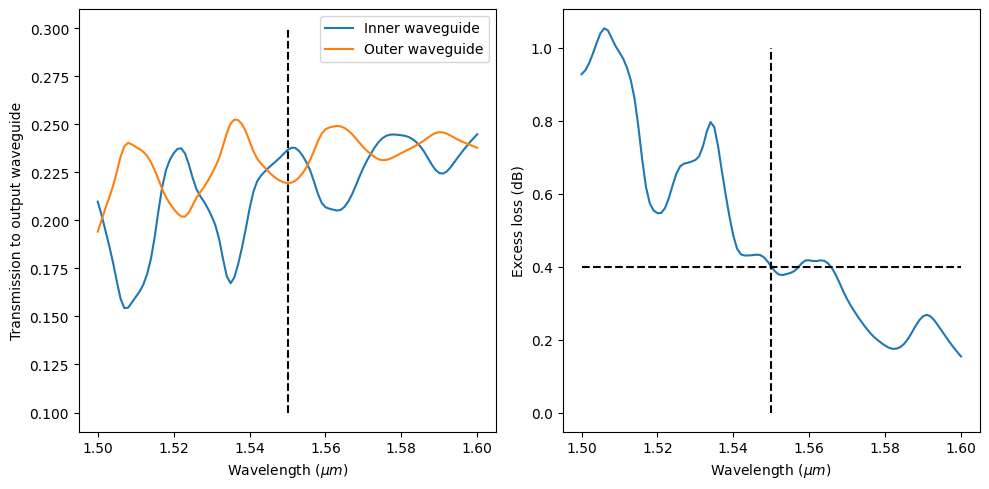

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.vlines(x=1.55, ymin=0.1, ymax=0.3, colors="black", ls="--")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission to output waveguide")
plt.legend(("Inner waveguide", "Outer waveguide"))

plt.sca(ax2)
excess_loss = -10 * np.log10(2 * (T1 + T2))
plt.plot(ldas, excess_loss)
plt.vlines(x=1.55, ymin=0, ymax=1, colors="black", ls="--")
plt.hlines(y=excess_loss[50], xmin=1.5, xmax=1.6, colors="black", ls="--")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Excess loss (dB)")
plt.show()


We can use the mode monitor to inspect the composition of each mode at the output. For the outer waveguide, we can see that the fundamental mode is dominant.

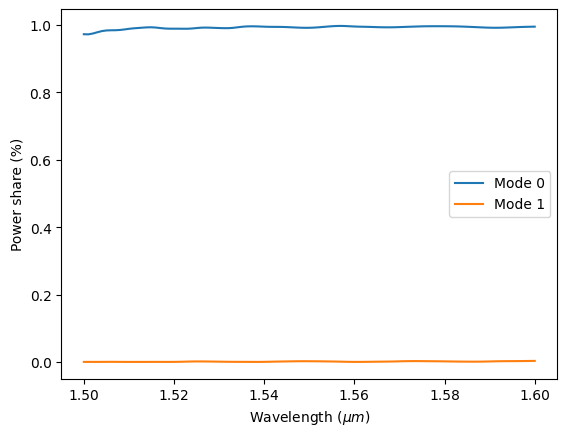

In [10]:
mode_amp = sim_data["mode2"].amps.sel(direction="+")
mode_power = np.abs(mode_amp) ** 2 / T2
plt.plot(ldas, mode_power)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Power share (%)")
plt.legend(["Mode 0", "Mode 1"])
plt.show()


## Optimization 

Further tuning of the geometric parameters is likely to improve the device's performance further. We will perform a parameter sweep on two parameters to see if we can optimize the MMI. The goal is to achieve even power splitting among output waveguides while keeping the excess loss low.

The length of the MMI is swept from 11.1 to 11.2 $\mu m$ in 50 nm step and the width from 4.8 to 5 $\mu m$ in 100 nm step. This results in a total of 9 simulations. Since this is just a demonstration model, we limit the total number of simulations for the sake of time. In practice, one can perform much larger parameter sweeps to cover a larger parameter space.


In [11]:
L_MMIs = np.linspace(11.1, 11.2, 3)  # MMI length varies from 11.1 to 11.2 um
W_MMIs = np.linspace(4.8, 5, 3)  # MMI width varies from 4.8 to 5 um

sims = {
    f"L_MMI={L_MMI:.2f};W_MMI={W_MMI:.2f}": make_sim(L_MMI, W_MMI)
    for L_MMI in L_MMIs
    for W_MMI in W_MMIs
}
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")


[13:13:18] WARNING: Default value for the field monitor           ]8;id=684508;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=823075;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=313617;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=907451;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=725751;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=93954;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=822486;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=677357;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=556708;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=268307;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=600499;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=280660;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=222307;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=68346;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=43063;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=782141;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=352413;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=703289;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           Created task 'L_MMI=11.10;W_MMI=4.80' with task_id      ]8;id=799280;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=661735;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1'.                       

           View task using web UI at                               ]8;id=707554;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=406762;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=814838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=733781;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1\taskId]8;;\]8;id=814838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1\=]8;;\]8;id=369853;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1\fdve]8;;\]8;id=814838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1\-]8;;\              
           ]8;id=814838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1\e146df9a-d0d1-4496-9739-2d23f8b414e9v1']8;;\.                             

Output()

           Created task 'L_MMI=11.10;W_MMI=4.90' with task_id      ]8;id=712635;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=170421;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1'.                       

           View task using web UI at                               ]8;id=985166;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=35664;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=868639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=515036;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1\taskId]8;;\]8;id=868639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1\=]8;;\]8;id=53733;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1\fdve]8;;\]8;id=868639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1\-]8;;\              
           ]8;id=868639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1\15f04405-2f42-4adb-a000-6ab329aaf5c6v1']8;;\.                             

Output()

[13:13:19] Created task 'L_MMI=11.10;W_MMI=5.00' with task_id      ]8;id=924003;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=552316;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1'.                       

           View task using web UI at                               ]8;id=700528;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=525581;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=395978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=343233;https://tidy3d.simulation.cloud/workbench?taskId=fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1\taskId]8;;\]8;id=395978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1\=]8;;\]8;id=75033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1\fdve]8;;\]8;id=395978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1\-]8;;\              
           ]8;id=395978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1\513f26a5-700e-4e0d-b98f-ca1697904f0cv1']8;;\.                             

Output()

           Created task 'L_MMI=11.15;W_MMI=4.80' with task_id      ]8;id=468215;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=346037;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1'.                       

           View task using web UI at                               ]8;id=1927;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=224801;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=857085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=494320;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1\taskId]8;;\]8;id=857085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1\=]8;;\]8;id=430739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1\fdve]8;;\]8;id=857085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1\-]8;;\              
           ]8;id=857085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1\5046cd19-7d86-433d-9c85-19c1e900f9dcv1']8;;\.                             

Output()

[13:13:20] Created task 'L_MMI=11.15;W_MMI=4.90' with task_id      ]8;id=582156;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=793129;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1'.                       

           View task using web UI at                               ]8;id=251232;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=695331;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=82681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=377354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1\taskId]8;;\]8;id=82681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1\=]8;;\]8;id=418631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1\fdve]8;;\]8;id=82681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1\-]8;;\              
           ]8;id=82681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1\4ae1d2c0-9311-4dab-aa92-aec44474bffev1']8;;\.                             

Output()

           Created task 'L_MMI=11.15;W_MMI=5.00' with task_id      ]8;id=460255;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=114680;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-13908e29-319b-4a3c-944c-833f4200b341v1'.                       

           View task using web UI at                               ]8;id=800783;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=154322;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=598647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13908e29-319b-4a3c-944c-833f4200b341v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=735757;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13908e29-319b-4a3c-944c-833f4200b341v1\taskId]8;;\]8;id=598647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13908e29-319b-4a3c-944c-833f4200b341v1\=]8;;\]8;id=541475;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13908e29-319b-4a3c-944c-833f4200b341v1\fdve]8;;\]8;id=598647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13908e29-319b-4a3c-944c-833f4200b341v1\-]8;;\              
           ]8;id=598647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-13908e29-319b-4a3c-944c-833f4200b341v1\13908e29-319b-4a3c-944c-833f4200b341v1']8;;\.                             

Output()

           Created task 'L_MMI=11.20;W_MMI=4.80' with task_id      ]8;id=548131;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=600280;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1'.                       

           View task using web UI at                               ]8;id=129200;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=686810;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=3514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=59737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1\taskId]8;;\]8;id=3514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1\=]8;;\]8;id=617845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1\fdve]8;;\]8;id=3514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1\-]8;;\              
           ]8;id=3514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1\c8db1bec-419e-4f1c-a4df-89493329f6c2v1']8;;\.                             

Output()

[13:13:21] Created task 'L_MMI=11.20;W_MMI=4.90' with task_id      ]8;id=761667;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=391049;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1'.                       

           View task using web UI at                               ]8;id=55763;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=796396;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=646872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=175236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1\taskId]8;;\]8;id=646872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1\=]8;;\]8;id=286218;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1\fdve]8;;\]8;id=646872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1\-]8;;\              
           ]8;id=646872;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1\0534f858-4b17-49b6-80da-0735e1d5e59fv1']8;;\.                             

Output()

           Created task 'L_MMI=11.20;W_MMI=5.00' with task_id      ]8;id=32456;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=405012;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1'.                       

           View task using web UI at                               ]8;id=268870;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=267267;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=250029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=366453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1\taskId]8;;\]8;id=250029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1\=]8;;\]8;id=260558;https://tidy3d.simulation.cloud/workbench?taskId=fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1\fdve]8;;\]8;id=250029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1\-]8;;\              
           ]8;id=250029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1\155f10f6-ed62-4cfc-b565-b64f0577f463v1']8;;\.                             

Output()

[13:13:24] Started working on Batch.                            ]8;id=855129;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=875056;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[13:14:36] Maximum FlexCredit cost: 2.223 for the whole batch.  ]8;id=149747;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=848761;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[13:16:32] Batch complete.                                      ]8;id=847289;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=878548;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Parse flux data into numpy arrays.

In [12]:
T1 = np.zeros((len(L_MMIs), len(W_MMIs)))
T2 = np.zeros((len(L_MMIs), len(W_MMIs)))
for i, L_MMI in enumerate(L_MMIs):
    for j, W_MMI in enumerate(W_MMIs):
        sim_data = batch_results[f"L_MMI={L_MMI:.2f};W_MMI={W_MMI:.2f}"]
        t1 = sim_data["flux1"].flux
        T1[i, j] = t1[50]  # the index 50 corresponds to the wavelength of 1550 nm
        t2 = sim_data["flux2"].flux
        T2[i, j] = t2[50]


Output()

[13:16:35] loading SimulationData from                             ]8;id=759114;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=147337;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-e146df9a-d0d1-4496-9739-2d23f8b414e9v1.hdf5                

Output()

[13:16:36] loading SimulationData from                             ]8;id=548616;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=829377;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-15f04405-2f42-4adb-a000-6ab329aaf5c6v1.hdf5                

Output()

[13:16:37] loading SimulationData from                             ]8;id=211395;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=715925;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-513f26a5-700e-4e0d-b98f-ca1697904f0cv1.hdf5                

Output()

[13:16:38] loading SimulationData from                             ]8;id=81937;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=267369;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-5046cd19-7d86-433d-9c85-19c1e900f9dcv1.hdf5                

Output()

[13:16:39] loading SimulationData from                             ]8;id=931032;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=265964;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1.hdf5                

Output()

[13:16:45] loading SimulationData from                             ]8;id=306079;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=299165;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-13908e29-319b-4a3c-944c-833f4200b341v1.hdf5                

Output()

[13:16:46] loading SimulationData from                             ]8;id=80719;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380640;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-c8db1bec-419e-4f1c-a4df-89493329f6c2v1.hdf5                

Output()

[13:16:47] loading SimulationData from                             ]8;id=906143;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=84184;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-0534f858-4b17-49b6-80da-0735e1d5e59fv1.hdf5                

Output()

[13:16:49] loading SimulationData from                             ]8;id=62986;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255872;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-155f10f6-ed62-4cfc-b565-b64f0577f463v1.hdf5                

Visualize power difference between outputs as well as the excess loss. The optimal design would have both values as close to 0 as possible. From the plots, we can see that in this parameter range, the smallest power different does not coincide with the lowest excess loss. If we prioritize small power difference, for example, L_MMI = 11.15 $\mu m$ and W_MMI = 4.9 $\mu m$ would be a good design choice.

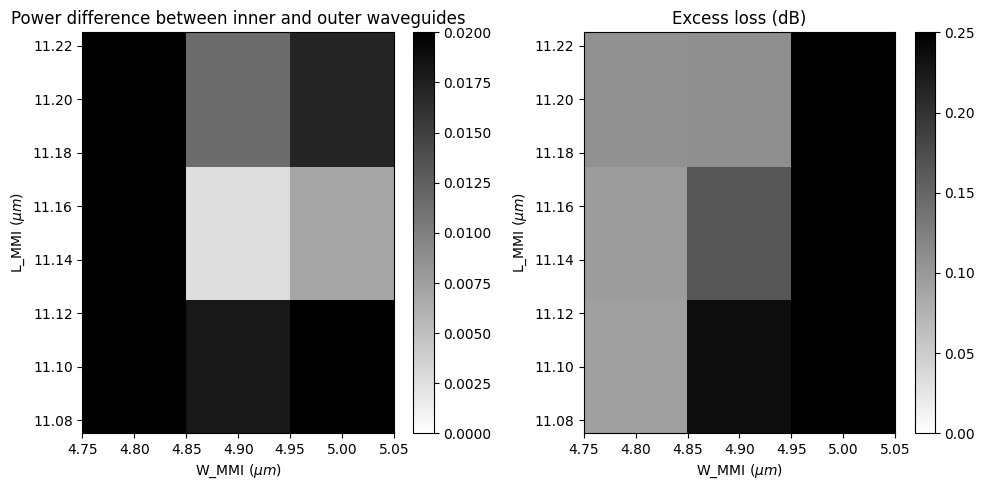

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
plt.sca(ax1)
plt.pcolor(W_MMIs, L_MMIs, np.abs(T1 - T2), vmin=0, vmax=0.02, cmap="binary")
plt.colorbar()
plt.title("Power difference between inner and outer waveguides")
plt.xlabel("W_MMI ($\mu m$)")
plt.ylabel("L_MMI ($\mu m$)")
plt.sca(ax2)
plt.pcolor(
    W_MMIs, L_MMIs, -10 * np.log10(2 * (T1 + T2)), vmin=0, vmax=0.25, cmap="binary"
)
plt.colorbar()
plt.title("Excess loss (dB)")
plt.xlabel("W_MMI ($\mu m$)")
plt.ylabel("L_MMI ($\mu m$)")
plt.show()


Plot field intensity for the optimal design.

[13:16:50] loading SimulationData from                             ]8;id=503673;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=601345;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-4ae1d2c0-9311-4dab-aa92-aec44474bffev1.hdf5                

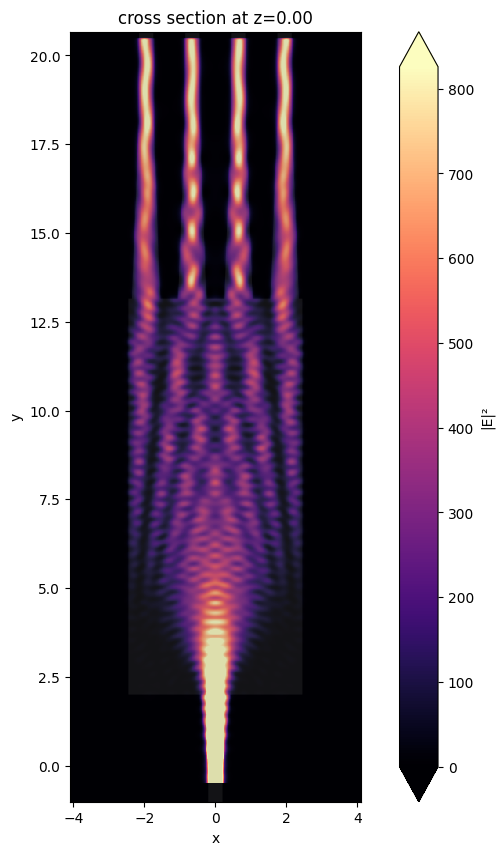

In [14]:
sim_data = batch_results["L_MMI=11.15;W_MMI=4.90"]
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", ax=ax, f=freq0
)
plt.show()


Plot transmission on each output waveguide as well as the total excess loss. For this design, at the central wavelength of 1.55 $\mu m$, the power on each power is roughly equal. The total excess loss is below 0.2 dB.

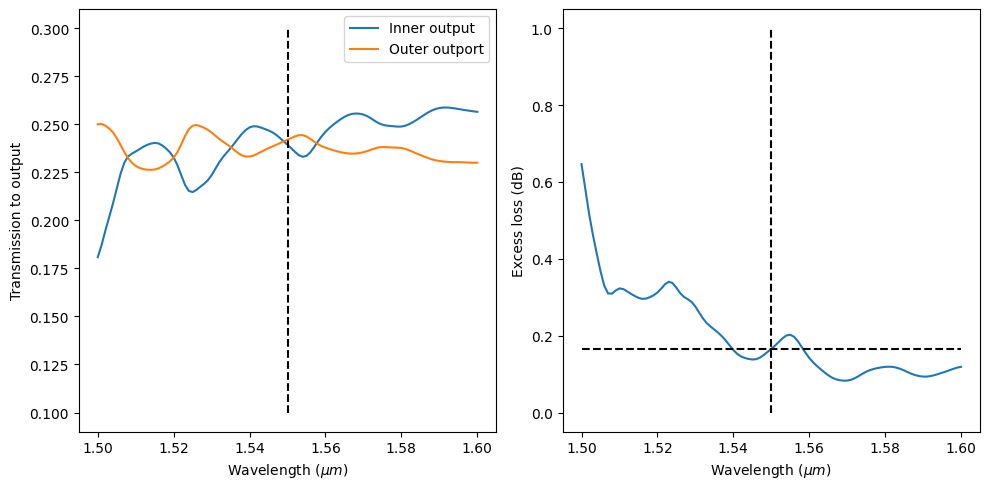

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.vlines(x=1.55, ymin=0.1, ymax=0.3, colors="black", ls="--")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission to output")
plt.legend(("Inner output", "Outer outport"))

plt.sca(ax2)
excess_loss = -10 * np.log10(2 * (T1 + T2))
plt.plot(ldas, excess_loss)
plt.vlines(x=1.55, ymin=0, ymax=1, colors="black", ls="--")
plt.hlines(y=excess_loss[50], xmin=1.5, xmax=1.6, colors="black", ls="--")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Excess loss (dB)")
plt.show()


In principle, the design can be further optimized by tuning other parameters such as gap size, tapper width, etc. if even lower excess loss is required.
Finally, we can see the mode decomposition at the outer output waveguide. The fundamental mode is still dominant.

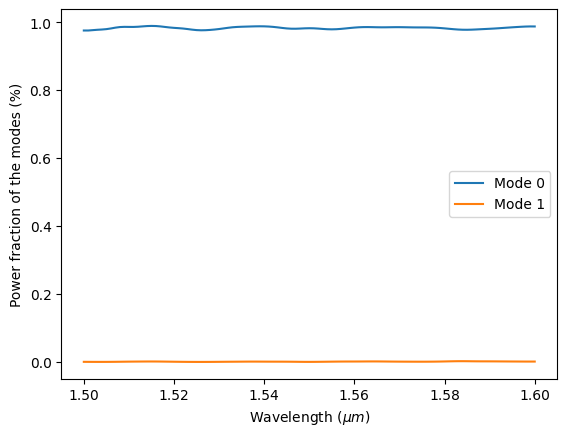

In [16]:
mode_amp = sim_data["mode2"].amps.sel(direction="+")
mode_power = np.abs(mode_amp) ** 2 / T2
plt.plot(ldas, mode_power)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Power fraction of the modes (%)")
plt.legend(["Mode 0", "Mode 1"])
plt.show()
